[home](http://www.brandonrose.org)

# Document Clustering with Python

<img src='https://user-images.githubusercontent.com/43749571/96265717-c40a8400-1000-11eb-9e4f-cc55dbff4e29.jpg'>

In this guide, I will explain how to cluster a set of documents using Python. My motivating example is to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list). See [the original post](http://www.brandonrose.org/top100) for a more detailed discussion on the example. This guide covers:




* tokenizing and stemming each synopsis
* transforming the corpus into vector space using [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
* calculating cosine distance between each document as a measure of similarity
* clustering the documents using the [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
* using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling) to reduce dimensionality within the corpus 
* plotting the clustering output using [matplotlib](http://matplotlib.org/) and [mpld3](http://mpld3.github.io/)
* conducting a hierarchical clustering on the corpus using [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
* plotting a Ward dendrogram
* topic modeling using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)

## Contents

* [Stopwords, stemming, and tokenization](#Stopwords,-stemming,-and-tokenizing)
* [Tf-idf and document similarity](#Tf-idf-and-document-similarity)
* [K-means clustering](#K-means-clustering)
* [Multidimensional scaling](#Multidimensional-scaling)
* [Visualizing document clusters](#Visualizing-document-clusters)
* [Hierarchical document clustering](#Hierarchical-document-clustering)
* [Latent Dirichlet Allocation (LDA)](#Latent-Dirichlet-Allocation)

But first, I import everything I am going to need up front

In [3]:
import numpy as np
import pandas as pd

import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs

from sklearn import feature_extraction
import mpld3

# Stopwords, stemming, and tokenizing

In [4]:
#import three lists: titles, links and wikipedia synopses
titles = open('title_list.txt').read().split('\n')
#ensures that only the first 100 are read in
titles = titles[:100]

links = open('link_list_imdb.txt').read().split('\n')
links = links[:100]

synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)

synopses_wiki = synopses_clean_wiki
    
    
genres = open('genres_list.txt').read().split('\n')
genres = genres[:100]

print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopses_wiki)) + ' synopses')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 synopses
100 genres


In [5]:
synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

synopses_clean_imdb = []
for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

In [6]:
synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

In [7]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

This section is focused on defining some functions to manipulate the synopses. First, I load [NLTK's](http://www.nltk.org/) list of English stop words. [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning. I'm sure there are much better explanations of this out there.

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/jbeen/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

Next I import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [9]:
# load nltk's SnowballStemmer as variabled 'stemmer' -> Lemmatizer 
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


Below I define two functions:


* **tokenize_and_stem**: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token 
* **tokenize_only**: tokenizes the synopsis only


I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!



In [10]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [19]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/jbeen/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
totalvocab_stemmed = []  
totalvocab_tokenized = []

for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [12]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [13]:
vocab_frame

,words
plot,plot
edit,edit
edit,edit
edit,edit
on,on
...,...
join,join
in,in
which,which
he,he


## Tf-idf and document similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document **frequency weighting**: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:



* max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
* min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
* ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                   min_df=0.2, stop_words='english',
                                   use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time 
tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/Users/jbeen/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(100, 563)


In [15]:
terms = tfidf_vectorizer.get_feature_names()

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima. 

In [17]:
import sklearn.externals.joblib as joblib

/Users/jbeen/anaconda3/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [18]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)

%time 
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 6.91 µs


In [20]:
import pickle as pkl

with open('doc_cluster.pkl', 'rb') as f:
    km = pkl.load(f)
    
clusters = km.labels_

In [26]:
clusters  

In [27]:
_ = joblib.dump(clusters, "clusters.npy", compress=5) # NDArrayWrapper : sklearn.externals.joblib 과 joblib 사이에 계속 충돌이 나서.. npy로 저장한 다음에 다시 불러옴 ^_^

In [28]:
clusters2 = joblib.load("clusters.npy") 

<ipython-input-28-35c2d67e0b16>:1: DeprecationWarning: The file 'clusters.npy' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  clusters2 = joblib.load("clusters.npy")


In [29]:
clusters2

array([2, 4, 0, 2, 1, 0, 0, 2, 0, 0, 4, 2, 1, 1, 1, 2, 0, 4, 3, 4, 0, 4,
       0, 1, 4, 3, 3, 3, 2, 4, 1, 4, 0, 4, 4, 4, 4, 4, 4, 2, 0, 3, 2, 3,
       0, 0, 0, 0, 4, 4, 2, 2, 4, 4, 2, 4, 1, 4, 0, 2, 0, 4, 4, 1, 2, 3,
       2, 3, 2, 2, 2, 2, 0, 0, 0, 3, 1, 0, 0, 4, 4, 0, 2, 3, 0, 3, 1, 4,
       0, 4, 1, 1, 2, 0, 1, 1, 2, 1, 1, 3], dtype=int32)

In [30]:
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters2, 'genre': genres }
frame = pd.DataFrame(films, index = [clusters2] , columns = ['rank', 'title', 'cluster', 'genre'])

In [31]:
frame['cluster'].value_counts()

4    26
0    25
2    21
1    16
3    12
Name: cluster, dtype: int64

In [32]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()

cluster
0    47.200000
1    58.875000
2    49.380952
3    54.500000
4    43.730769
Name: rank, dtype: float64

In [34]:
km.cluster_centers_

In [38]:
_ = joblib.dump(km.cluster_centers_, "cluster_centers_.npy", compress=5)
cluster_centers = joblib.load("cluster_centers_.npy") 

<ipython-input-38-9e139271481a>:2: DeprecationWarning: The file 'cluster_centers_.npy' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  cluster_centers = joblib.load("cluster_centers_.npy")


In [39]:
cluster_centers

array([[0.00696897, 0.01138514, 0.01203234, ..., 0.01030939, 0.03292249,
        0.01187134],
       [0.01330645, 0.02636773, 0.00989454, ..., 0.01280072, 0.02505616,
        0.00804739],
       [0.00633176, 0.01015614, 0.02072936, ..., 0.09794459, 0.03146009,
        0.00749326],
       [0.02400191, 0.00289602, 0.01795369, ..., 0.02637798, 0.01009011,
        0.00434982],
       [0.00675671, 0.00897455, 0.00041218, ..., 0.00110324, 0.01959045,
        0.00486994]])

In [40]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = cluster_centers.argsort()[:, ::-1]

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'family', b'home', b'mother', b'war', b'house', b'dies',

Cluster 0 titles: Schindler's List, One Flew Over the Cuckoo's Nest, Gone with the Wind, The Wizard of Oz, Titanic, Forrest Gump, E.T. the Extra-Terrestrial, The Silence of the Lambs, Gandhi, A Streetcar Named Desire, The Best Years of Our Lives, My Fair Lady, Ben-Hur, Doctor Zhivago, The Pianist, The Exorcist, Out of Africa, Good Will Hunting, Terms of Endearment, Giant, The Grapes of Wrath, Close Encounters of the Third Kind, The Graduate, Stagecoach, Wuthering Heights,

Cluster 1 words: b'police', b'car', b'killed', b'murders', b'driving', b'house',

Cluster 1 titles: Casablanca, Psycho, Sunset Blvd., Vertigo, Chinatown, Amadeus, High Noon, The French Connection, Fargo, Pulp Fiction, The Maltese Falcon, A Clockwork Orange, Double Indemnity, Rebel Without a Cause, The Third Man, North by Northwest,

Cluster 2 words: b'father', b'new', b'york', b'new', b'brothers', b'apartments',

Clust

In [41]:
#This is purely to help export tables to html and to correct for my 0 start rank (so that Godfather is 1, not 0)
frame['Rank'] = frame['rank'] + 1
frame['Title'] = frame['title']

In [74]:
frame[['Rank', 'Title']].loc[frame['cluster'] == 1]

,Rank,Title
1,5,Casablanca
1,13,Psycho
1,14,Sunset Blvd.
1,15,Vertigo
1,24,Chinatown
1,31,Amadeus
1,57,High Noon
1,64,The French Connection
1,77,Fargo
1,87,Pulp Fiction


In [42]:
#export tables to HTML
print(frame[['Rank', 'Title']].loc[frame['cluster'] == 1].to_html(index=False))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Rank</th>
      <th>Title</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>5</td>
      <td>Casablanca</td>
    </tr>
    <tr>
      <td>13</td>
      <td>Psycho</td>
    </tr>
    <tr>
      <td>14</td>
      <td>Sunset Blvd.</td>
    </tr>
    <tr>
      <td>15</td>
      <td>Vertigo</td>
    </tr>
    <tr>
      <td>24</td>
      <td>Chinatown</td>
    </tr>
    <tr>
      <td>31</td>
      <td>Amadeus</td>
    </tr>
    <tr>
      <td>57</td>
      <td>High Noon</td>
    </tr>
    <tr>
      <td>64</td>
      <td>The French Connection</td>
    </tr>
    <tr>
      <td>77</td>
      <td>Fargo</td>
    </tr>
    <tr>
      <td>87</td>
      <td>Pulp Fiction</td>
    </tr>
    <tr>
      <td>91</td>
      <td>The Maltese Falcon</td>
    </tr>
    <tr>
      <td>92</td>
      <td>A Clockwork Orange</td>
    </tr>
    <tr>
      <td>95</td>
      <td>Double Indemnity</td>
    </tr>
    <tr

# Multidimensional scaling
* 다차원척도법 : https://wujincheon.github.io/wujincheon.github.io/machine%20learning/2018/10/23/pca&mds.html 
  * 원래 차원에서의 **거리순서**를 고려하면서 **저차원으로의 거리정보가 유지**되도록 하는 차원을 구하는 것
  * 시각적으로 객체간의 거리를 (유사한 정도를) 쉽게 해석하기 위해서 저차원으로 mapping 하는 것
  * 변수 자체의 해석보다는, 타겟으로 설정한 변수들이 어떤 관계를 가지는지, 객체들간의 관계를 보기쉽게 포지셔닝하는데 이용

In [43]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1] # pos : 객체들의 새로운 좌표 

In [44]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

## Visualizing document clusters

In [45]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

In [46]:
%matplotlib inline

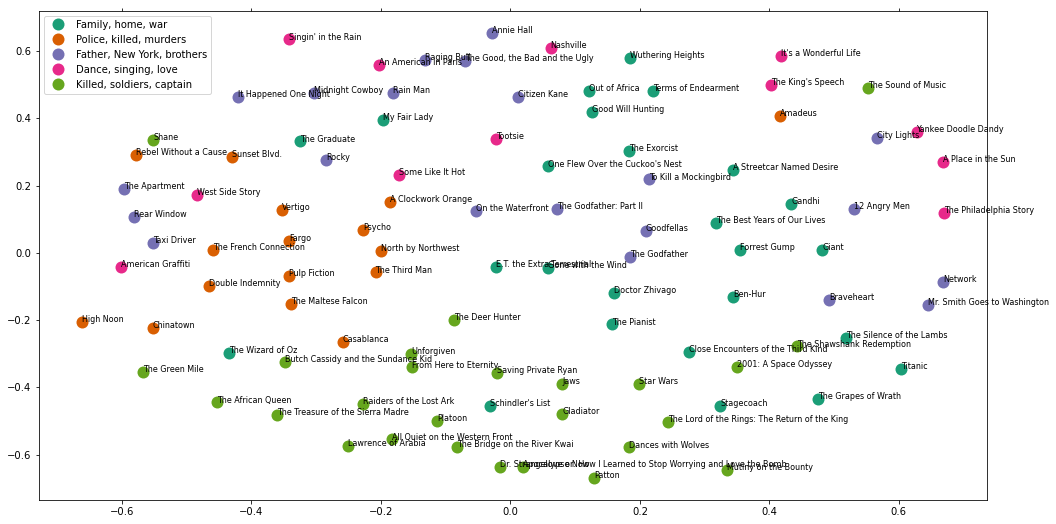

In [48]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters2, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [49]:
plt.close()

The clustering plot looks great, but it pains my eyes to see overlapping labels. Having some experience with [D3.js](http://d3js.org/) I knew one solution would be to use a browser based/javascript interactive. Fortunately, I recently stumbled upon [mpld3](https://mpld3.github.io/) a matplotlib wrapper for D3. Mpld3 basically let's you use matplotlib syntax to create web interactives. It has a really easy, high-level API for adding tooltips on mouse hover, which is what I am interested in.

It also has some nice functionality for zooming and panning. The below javascript snippet basicaly defines a custom location for where the zoom/pan toggle resides. Don't worry about it too much and you actually don't need to use it, but it helped for formatting purposes when exporting to the web later. The only thing you might want to change is the x and y attr for the position of the toolbar.

In [50]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [51]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters2, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

# Hierarchical document clustering

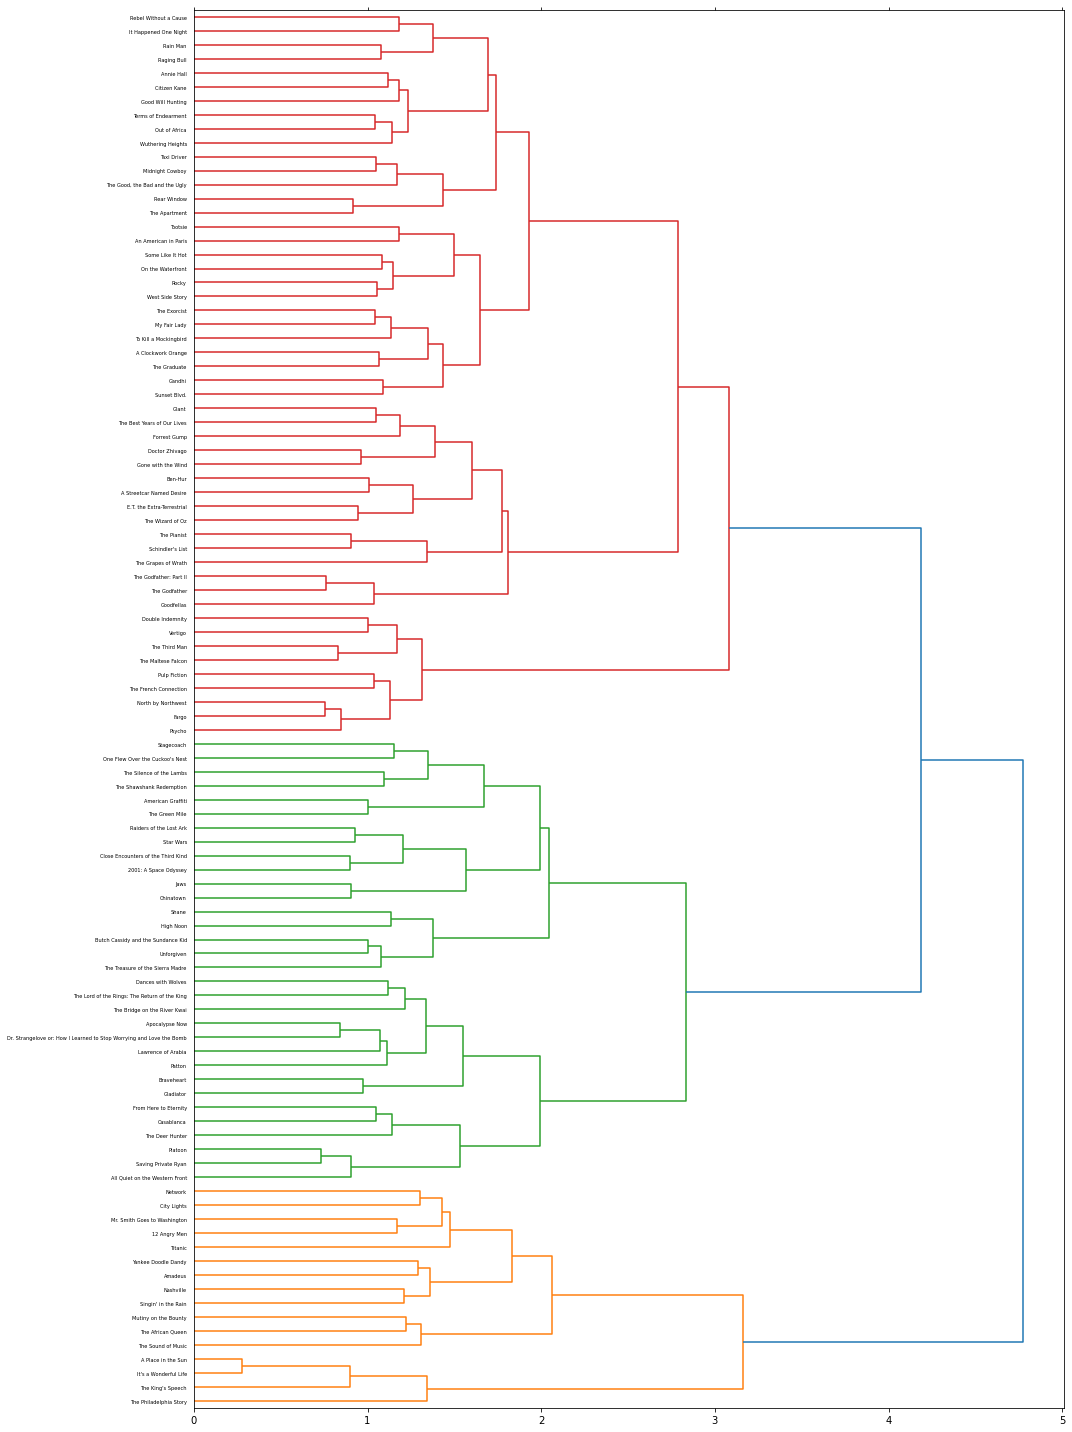

In [52]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [53]:
plt.close()

# Latent Dirichlet Allocation
* cf) https://12-03.tistory.com/2?category=720530

In [54]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [55]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [89]:
#Latent Dirichlet Allocation implementation with Gensim

from gensim import corpora, models, similarities 

#remove proper names
preprocess = [strip_proppers(doc) for doc in synopses]

%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 2.82 s, sys: 5.83 ms, total: 2.83 s
Wall time: 2.83 s
CPU times: user 306 ms, sys: 1.53 ms, total: 307 ms
Wall time: 307 ms


In [90]:
#print(len([word for word in texts[0] if word not in stopwords]))
print(len(texts[0]))

1839


In [91]:
dictionary = corpora.Dictionary(texts) # text 사전 구축 

In [92]:
dictionary.filter_extremes(no_below=1, no_above=0.8) # 너무 자주 나오거나, 너무 안 나오는 단어들 지우기 

In [93]:
corpus = [dictionary.doc2bow(text) for text in texts] # doc2bow : 문서 데이터 수치화 - 문서를 단어의 id와 빈도수로 수치화 (bow = bag of words)

In [94]:
len(corpus)

100

In [95]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 1min 58s, sys: 502 ms, total: 1min 58s
Wall time: 29.8 s


In [96]:
print(lda[corpus[0]])

[(0, 0.42289057), (1, 0.26024964), (2, 0.3166122)]


In [97]:
topics = lda.print_topics(5, num_words=20)

In [98]:
topics

[(0,
  '0.007*"father" + 0.007*"famili" + 0.005*"kill" + 0.004*"son" + 0.004*"ask" + 0.004*"meet" + 0.004*"n\'t" + 0.004*"friend" + 0.004*"sing" + 0.003*"love" + 0.003*"becom" + 0.003*"polic" + 0.003*"brother" + 0.003*"show" + 0.003*"film" + 0.003*"night" + 0.003*"refus" + 0.003*"also" + 0.003*"murder" + 0.003*"go"'),
 (1,
  '0.006*"car" + 0.005*"ask" + 0.005*"meet" + 0.005*"kill" + 0.005*"apart" + 0.005*"call" + 0.004*"polic" + 0.004*"go" + 0.004*"friend" + 0.004*"say" + 0.004*"n\'t" + 0.004*"two" + 0.004*"night" + 0.004*"doe" + 0.004*"arriv" + 0.004*"goe" + 0.004*"day" + 0.004*"offic" + 0.004*"want" + 0.003*"next"'),
 (2,
  '0.008*"kill" + 0.006*"men" + 0.005*"soldier" + 0.005*"order" + 0.004*"two" + 0.004*"arriv" + 0.004*"attack" + 0.003*"offic" + 0.003*"home" + 0.003*"n\'t" + 0.003*"escap" + 0.003*"ship" + 0.003*"famili" + 0.003*"fire" + 0.003*"camp" + 0.003*"set" + 0.003*"command" + 0.003*"help" + 0.003*"group" + 0.003*"sever"'),
 (3,
  '0.005*"home" + 0.004*"friend" + 0.004*"go" 

In [99]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

In [100]:
topics_matrix = np.array(topics_matrix)

In [101]:
topics_matrix

array([[0,
        list([('father', 0.007152229), ('famili', 0.0065334467), ('kill', 0.0048802835), ('son', 0.0044699544), ('ask', 0.0042116386), ('meet', 0.004099474), ("n't", 0.0037404401), ('friend', 0.0036956642), ('sing', 0.0036420985), ('love', 0.0034754174), ('becom', 0.0034734365), ('polic', 0.0034406339), ('brother', 0.0033877755), ('show', 0.0031788712), ('film', 0.0031714437), ('night', 0.00310722), ('refus', 0.0030975854), ('also', 0.0030634608), ('murder', 0.0030321407), ('go', 0.003024812)])],
       [1,
        list([('car', 0.0061929226), ('ask', 0.0054927017), ('meet', 0.005228406), ('kill', 0.0051161973), ('apart', 0.0047563217), ('call', 0.0047073206), ('polic', 0.004487032), ('go', 0.0042926674), ('friend', 0.0041936752), ('say', 0.0040315017), ("n't", 0.0040199934), ('two', 0.0038845725), ('night', 0.0038321435), ('doe', 0.0038021842), ('arriv', 0.0037961483), ('goe', 0.0037848162), ('day', 0.0037815443), ('offic', 0.0037363481), ('want', 0.003727335), ('next', 0.0

In [102]:
topics_matrix.shape

(5, 2)

In [110]:
for i in topic_words:
    print([word[0] for word in i])
    print()

['father', 'famili', 'kill', 'son', 'ask', 'meet', "n't", 'friend', 'sing', 'love', 'becom', 'polic', 'brother', 'show', 'film', 'night', 'refus', 'also', 'murder', 'go']

['car', 'ask', 'meet', 'kill', 'apart', 'call', 'polic', 'go', 'friend', 'say', "n't", 'two', 'night', 'doe', 'arriv', 'goe', 'day', 'offic', 'want', 'next']

['kill', 'men', 'soldier', 'order', 'two', 'arriv', 'attack', 'offic', 'home', "n't", 'escap', 'ship', 'famili', 'fire', 'camp', 'set', 'command', 'help', 'group', 'sever']

['home', 'friend', 'go', 'day', 'shark', 'run', 'say', 'mother', 'hous', 'love', 'first', 'away', 'life', 'father', 'come', 'want', 'two', 'famili', 'name', 'ask']

['film', 'kill', 'command', 'say', 'life', 'order', 'attempt', 'gold', 'bandit', 'attack', 'first', 'end', 'way', 'offic', 'fight', 'dure', 'later', 'home', 'death', 'father']

